# Ecommerce Logistics Analysis, Part 6
### Delivery Time Prediction

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from table_audit import table_audit_function
import math as m
pd.set_option('display.max_columns', 100)

%matplotlib inline

#Create context manager to handle connection to SQLite database and return dataframe from query
def run_query(q):
    with sqlite3.connect('data/ecommerce.db') as conn:
        return pd.read_sql_query(q,conn)

Below is a schema summarizing the relationships between the tables in the database I created in Part 1:
![title](images/schema_rearranged_2.jpg)

In [2]:
# See Part 4 where I created the view, 'orders_delivered_summary'
q1 = '''
SELECT *
FROM orders_delivered_summary
'''

df = run_query(q1)
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier,order_delivered_customer_date,order_estimated_delivery_date,quantity,product_id,seller_id,shipping_limit_date,price,price_full_quantity,freight_value,freight_value_full_quantity,GROUP_CONCAT(opm.payment_sequential),GROUP_CONCAT(opm.payment_type),GROUP_CONCAT(opm.payment_installments),GROUP_CONCAT(opm.payment_value),MAX(opm.payment_sequential),SUM(opm.payment_installments),SUM(opm.payment_value),customer_id:1,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,c_lat,c_lng,Customer_Urban_City,Customer_Urban_Distance,Customer_Urban,seller_id:1,seller_zip_code_prefix,seller_city,seller_state,s_lat,s_lng,Seller_Urban_City,Seller_Urban_Distance,Seller_Urban,product_id:1,product_category_name,product_name_length,product_description_height,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipment_outcome
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,58.90,13.29,13.29,1,credit_card,2,72.19,1.0,2.0,72.19,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,Campos Dos Goytacazes,1.222070,1.0,48436dade18ac8b2bce089ec2a041202,27277,volta redonda,SP,-22.498183,-44.123614,Volta Redonda,2.086410,1.0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58,598,4,650,28,9,14,Early delivery
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,239.90,19.93,19.93,1,credit_card,3,259.83,1.0,3.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.212393,-50.941471,Santa Fé Do Sul,0.954019,1.0,dd7ddc04e1b6c2c614352b383efe2d36,3471,sao paulo,SP,-23.566258,-46.518417,São Paulo,3.292157,1.0,e5f2d52b802189ee658865ca93d83a8f,pet_shop,56,239,2,30000,50,30,40,Early delivery
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,199.00,17.87,17.87,1,credit_card,5,216.87,1.0,5.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.860439,-44.597972,Pará De Minas,0.565696,1.0,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.264094,-46.158564,Pouso Alegre,14.351862,1.0,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,59,695,2,3050,33,13,33,Early delivery
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.99,12.79,12.79,1,credit_card,2,25.78,1.0,2.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.144923,-46.539830,Atibaia,2.201440,1.0,9d7a1d34a5052409006425275ba1c2b4,14403,franca,SP,-20.548228,-47.395897,Franca,0.935914,1.0,7634da152a4610f1595efa32f14722fc,perfumaria,42,480,1,200,16,10,15,Early delivery
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,199.90,18.14,18.14,1,credit_card,3,218.04,1.0,3.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.24900

#### Missing Values

In [3]:
# Using the function I created to audit this dataframe.


table_audit_function(df)

There are 1 null values in the field GROUP_CONCAT(opm.payment_sequential)
There are 1 null values in the field GROUP_CONCAT(opm.payment_type)
There are 1 null values in the field GROUP_CONCAT(opm.payment_installments)
There are 1 null values in the field GROUP_CONCAT(opm.payment_value)
There are 1 null values in the field MAX(opm.payment_sequential)
There are 1 null values in the field SUM(opm.payment_installments)
There are 1 null values in the field SUM(opm.payment_value)
There are 255 null values in the field c_lat
There are 255 null values in the field c_lng
There are 255 null values in the field Customer_Urban_City
There are 255 null values in the field Customer_Urban_Distance
There are 255 null values in the field Customer_Urban
There are 209 null values in the field s_lat
There are 209 null values in the field s_lng
There are 209 null values in the field Seller_Urban_City
There are 209 null values in the field Seller_Urban_Distance
There are 209 null values in the field Seller_U

<b>Notes</b>:<br> I will need to deal w/ the missing values in a given column only if I end up using that column as a predictive feature. 

Need to deal with records with null or blank values in the following fields:
1. c_lat, c_lng, Customer_Urban_City, Customer_Urban_Distance, Customer_Urban all have the same 255 null values:<br>
2. s_lat, s_lng, Seller_Urban_City, Seller_Urban_Distance, Seller_Urban all have the same 209 null values. <br>
    Too many unique cities to manually update coordinates.<br>
    Could impute with general coordinates of the state (only 29 states)<br>
    For now, removing these rows<br>
3. order_delivered_customer_date is used in calculating the target variable (8 blank values.)<br>
    Need to delete the 8 records with blank value because it is used directly in calculating the target variable.<br>
4. product_weight_g, product_length_cm, product_height_cm, product_width_cm all have same 16 blank values.<br>
    15/16 of rows are for same product but no identifying info to input accurate information.<br>
    Could impute with average values?<br>
    For now, removing these rows<br>
5. SUM(opm.payment_value) has 1 null value. 

Will be dropping additional missing values from a particular field if I decide to incorporate that field in as a predictive feature.

Reminder that I am not using any fields/features that leak future information: Can only use information that would be known at the time of purchase as this is when Olist tells the customer their estimate for when the shipment is to be delivered. For example, can't use the field 'order_delivered_carrier' because there is no way of knowing with 100% confidence when the seller would drop off the order items to the carrier at the time the customer places the order.

In [4]:
#Convert the blank values to numpy null values:
df.replace('', np.nan, inplace=True)

# Convert to float dtype
df['product_photos_qty'] = df['product_photos_qty'].astype(float)
df['product_description_height'] = df['product_description_height'].astype(float)

# Impute the missing values in the columns 'product_description_height' and 'product_photos_qty':
# Imputing w/ the median value of each feature (using median rather than mean to minimize it being skewed by outliers)
median_product_description = df['product_description_height'].median()
median_photos_qty = df['product_photos_qty'].median()

df['product_description_height'] = df['product_description_height'].fillna(median_product_description)
df['product_photos_qty'] = df['product_photos_qty'].fillna(median_photos_qty)

In [5]:
columns_delete_null_blank = ['c_lat', 'c_lng', 'Customer_Urban_City', 'Customer_Urban_Distance', 'Customer_Urban', 's_lat', 's_lng', 'Seller_Urban_City', 'Seller_Urban_Distance', 'Seller_Urban', 'order_delivered_customer_date', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'SUM(opm.payment_value)']
print('Shape of df before:',df.shape)

# Drop null values specified (also drops the rows w/ formerly blank values)
df.dropna(subset=columns_delete_null_blank, axis=0, inplace=True)
print('Shape of df after:',df.shape)

Shape of df before: (93281, 52)
Shape of df after: (92793, 52)


In [6]:
# Missing values after:
table_audit_function(df)

There are 14 null values in the field order_approved_at
There are 1 null values in the field order_delivered_carrier
There are 1304 null values in the field product_category_name
There are 1304 null values in the field product_name_length
There are no blank values in any of the columns for this table.


#### End of missing values section

#### Target variable:  'days_to_deliver' 

Number of shipments that take more than 50 days:  649
Number of shipments that take more than 20 days:  13819


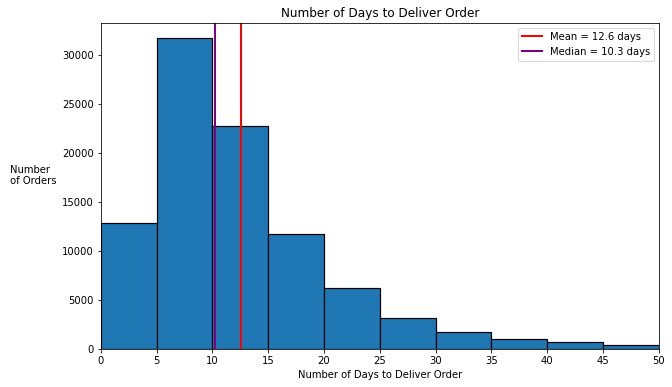

In [7]:
#Create 'days_to_deliver' to use as target variable.
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

# Creating target variable. This is what I am trying to predict.
df['days_to_deliver'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds()/(24*60*60)

# This is Olist's prediction
df['Olist_estimated_days_to_deliver'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.total_seconds()/(24*60*60)


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

#Histogram

print('Number of shipments that take more than 50 days: ', len(df[df['days_to_deliver']>50]))
print('Number of shipments that take more than 20 days: ', len(df[df['days_to_deliver']>20]))
ax1.hist(df['days_to_deliver'], range=(0,50), bins=10, edgecolor='black', linewidth=1.2)

mean_diff = df['days_to_deliver'].mean()
median_diff = df['days_to_deliver'].median()
ax1.axvline(x=mean_diff,c='red',label='Mean = ' + str(round(mean_diff,1)) + ' days', linewidth=2)
ax1.axvline(x=median_diff,c='purple',label='Median = ' + str(round(median_diff,1)) + ' days', linewidth=2)
ax1.set_ylabel('Number \n of Orders',rotation=0, labelpad=30)
ax1.set_xlabel('Number of Days to Deliver Order')
ax1.set_title('Number of Days to Deliver Order')
ax1.set_xticks([0,5,10,15,20,25,30,35,40,45,50])
ax1.set_xlim(0,50)
ax1.legend()
plt.savefig('images/days_to_deliver_hist.JPG',bbox_inches='tight', dpi=1200)
plt.show()

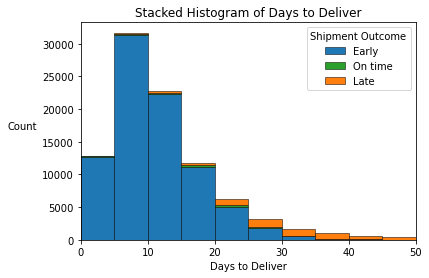

In [8]:
# Stacked histogram 

# Into 3 separate arrays:
# seller_to_carrier_days_early values for late deliveries: 
x1 = list(df.loc[df['shipment_outcome']=='Late delivery', 'days_to_deliver'])

# seller_to_carrier_days_early values for On time deliveries: 
x2 = list(df.loc[df['shipment_outcome']=='On time', 'days_to_deliver'])

# seller_to_carrier_days_early values for On time deliveries: 
x3 = list(df.loc[df['shipment_outcome']=='Early delivery', 'days_to_deliver'])

legend_labels = ['Early', 'On time', 'Late']

#Stack the data
plt.figure()

# Limit range from 15 days late to 15 days early
plt.hist([x3,x2,x1], color=['tab:blue', 'tab:green', 'tab:orange'], stacked=True, range=(0,50), bins=10, edgecolor='black', linewidth=0.5)
plt.xlim(0,50)

plt.title('Stacked Histogram of Days to Deliver')
plt.xlabel('Days to Deliver')
plt.ylabel('Count',rotation=0, labelpad=20)

plt.legend(title='Shipment Outcome', labels=legend_labels)

plt.savefig('images/stacked_histogram.JPG',bbox_inches='tight', dpi=1200)
plt.show()


Number of shipments that were estimated to take more than 50 days:  949


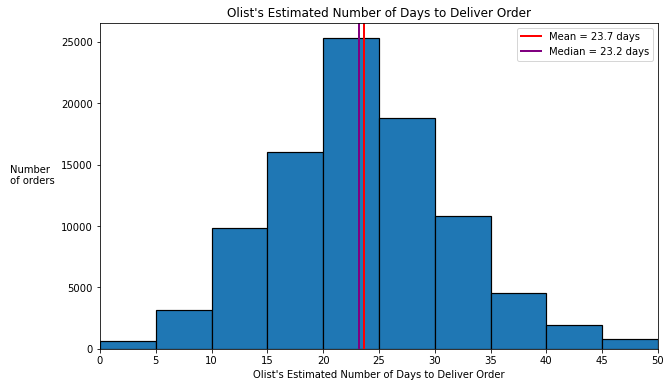

In [9]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

#Histogram

print('Number of shipments that were estimated to take more than 50 days: ', len(df[df['Olist_estimated_days_to_deliver']>50]))
ax1.hist(df['Olist_estimated_days_to_deliver'], range=(0,50), bins=10, edgecolor='black', linewidth=1.2)

mean_diff = df['Olist_estimated_days_to_deliver'].mean()
median_diff = df['Olist_estimated_days_to_deliver'].median()
ax1.axvline(x=mean_diff,c='red',label='Mean = ' + str(round(mean_diff,1)) + ' days', linewidth=2)
ax1.axvline(x=median_diff,c='purple',label='Median = ' + str(round(median_diff,1)) + ' days', linewidth=2)
ax1.set_ylabel('Number \n of orders',rotation=0, labelpad=30)
ax1.set_xlabel("Olist's Estimated Number of Days to Deliver Order")
ax1.set_title("Olist's Estimated Number of Days to Deliver Order")
ax1.set_xticks([0,5,10,15,20,25,30,35,40,45,50])
ax1.set_xlim(0,50)
ax1.legend()
plt.savefig('images/olist_estimation_hist.JPG',bbox_inches='tight', dpi=1200)
plt.show()

#### Feature Exploration

In [10]:
# From Section 4, create distance feature:

def haversine_dist(lat1,lng1,lat2,lng2):
    lat1_rad = lat1*m.pi/180
    lng1_rad = lng1*m.pi/180
    lat2_rad = lat2*m.pi/180
    lng2_rad = lng2*m.pi/180
    
    dist = 2*3959*m.asin((((m.sin((lat2_rad - lat1_rad)/2))**2) + m.cos(lat1_rad)*m.cos(lat2_rad)*((m.sin((lng2_rad - lng1_rad)/2))**2))**0.5)
    
    
    return dist

df['distance_est'] = df.apply(lambda x: haversine_dist(x['c_lat'],x['c_lng'],x['s_lat'],x['s_lng']), axis=1)

In [11]:
# Urban vs rural feature

In [12]:
# Convert financial columns from Brazilian Real to USD
# 1 Brazilian Real = 0.24 USD

financial_columns = ['price', 'price_full_quantity', 'freight_value', 'freight_value_full_quantity', 'SUM(opm.payment_value)']

for i in financial_columns:
    df[i] = df[i]*0.24

In [13]:
# Create 'shipping_limit_time' feature:
df['shipping_limit_time'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.total_seconds()/(24*60*60)

#Create product volume feature:
df['product_volume_cm3'] = df['product_length_cm']*df['product_width_cm']*df['product_height_cm']

num_same = len(df[(df['Seller_Urban_City']==df['Customer_Urban_City'])&(df['Customer_Urban']==1)&(df['Seller_Urban']==1)])
print('Number of shipments that stay within the same metropolitan area:',num_same)

#Seller and customer in same metropolitan area feature:
def same_metro_function(df_row):
    if (df_row['Customer_Urban']==1) & (df_row['Seller_Urban']==1) & (df_row['Seller_Urban_City']==df_row['Customer_Urban_City']):
        return 1
    else:
        return 0

df['same_metro'] = df.apply(lambda x: same_metro_function(x), axis=1)

Number of shipments that stay within the same metropolitan area: 1527


In [14]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier,order_delivered_customer_date,order_estimated_delivery_date,quantity,product_id,seller_id,shipping_limit_date,price,price_full_quantity,freight_value,freight_value_full_quantity,GROUP_CONCAT(opm.payment_sequential),GROUP_CONCAT(opm.payment_type),GROUP_CONCAT(opm.payment_installments),GROUP_CONCAT(opm.payment_value),MAX(opm.payment_sequential),SUM(opm.payment_installments),SUM(opm.payment_value),customer_id:1,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,c_lat,c_lng,Customer_Urban_City,Customer_Urban_Distance,Customer_Urban,seller_id:1,seller_zip_code_prefix,seller_city,seller_state,s_lat,s_lng,Seller_Urban_City,Seller_Urban_Distance,Seller_Urban,product_id:1,product_category_name,product_name_length,product_description_height,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipment_outcome,days_to_deliver,Olist_estimated_days_to_deliver,distance_est,shipping_limit_time,product_volume_cm3,same_metro
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,14.1360,14.1360,3.1896,3.1896,1,credit_card,2,72.19,1.0,2.0,17.3256,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,Campos Dos Goytacazes,1.222070,1.0,48436dade18ac8b2bce089ec2a041202,27277,volta redonda,SP,-22.498183,-44.123614,Volta Redonda,2.086410,1.0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,Early delivery,7.614421,15.625671,187.047783,6.032326,3528.0,0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,57.5760,57.5760,4.7832,4.7832,1,credit_card,3,259.83,1.0,3.0,62.3592,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.212393,-50.941471,Santa Fé Do Sul,0.954019,1.0,dd7ddc04e1b6c2c614352b383efe2d36,3471,sao paulo,SP,-23.566258,-46.518417,São Paulo,3.292157,1.0,e5f2d52b802189ee658865ca93d83a8f,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,Early delivery,16.216181,18.546458,366.180556,7.008414,60000.0,0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,47.7600,47.7600,4.2888,4.2888,1,credit_card,5,216.87,1.0,5.0,52.0488,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.860439,-44.597972,Pará De Minas,0.565696,1.0,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.264094,-46.158564,Pouso Alegre,14.351862,1.0,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,Early delivery,7.948437,21.393391,194.187395,4.010405,14157.0,0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,3.1176,3.1176,3.0696,3.0696,1,credit_card,2,25.78,1.0,2.0,6.1872,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.144923,-46.539830,Atibaia,2.201440,1.0,9d7a1d34a5052409006425275ba1c2b4,14403,franca,SP,-20.548228,-47.395897,Franca,0.935914,1.0,7634da152a4610f1595efa32f14722fc,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,Early delivery,6.147269,11.582928,187.635692,7.006748,2400.0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,201

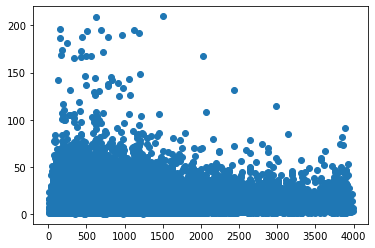

In [15]:
plt.scatter(df['product_description_height'],df['days_to_deliver'])
plt.show()

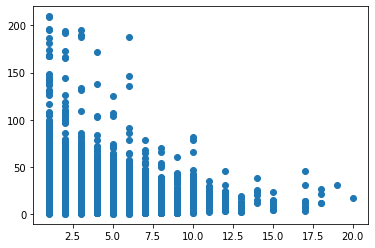

In [16]:
plt.scatter(df['product_photos_qty'],df['days_to_deliver'])
plt.show()

In [17]:
feature_list = ['distance_est', 'SUM(opm.payment_value)', 'product_weight_g', 'product_length_cm', 'Customer_Urban', 'Seller_Urban', 'freight_value_full_quantity', 'shipping_limit_time','product_volume_cm3', 'same_metro', 'product_description_height', 'product_photos_qty']

df[feature_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92793 entries, 0 to 93280
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance_est                 92793 non-null  float64
 1   SUM(opm.payment_value)       92793 non-null  float64
 2   product_weight_g             92793 non-null  float64
 3   product_length_cm            92793 non-null  float64
 4   Customer_Urban               92793 non-null  float64
 5   Seller_Urban                 92793 non-null  float64
 6   freight_value_full_quantity  92793 non-null  float64
 7   shipping_limit_time          92793 non-null  float64
 8   product_volume_cm3           92793 non-null  float64
 9   same_metro                   92793 non-null  int64  
 10  product_description_height   92793 non-null  float64
 11  product_photos_qty           92793 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 9.2 MB


## Evaluation Criteria

Need to choose a scoring metric for predicting the delivery time.


<b>Business goal</b>: 

1. Increase customer satisfaction: increase review scores by improving the delivery estimation system to reduce the number of late deliveries (shipments that are delivered after the estimated delivery date given to customer at the time of purchase)
2. Increase the number of purchases through Olist: Give less conservative delivery times (ie improve delivery estimate system to increase the number of on-time deliveries and decrease the number of early deliveries) so that customer will purchase through Olist –backed seller rather than through competitor (No data/statistics to back this. The business intuition is that potential customers may purchase through a competitor if they think that the delivery time will take longer through the Olist-backed seller).

Summary: Improve the delivery date estimation system such that:<br>
1. Decrease the number of late deliveries
2. Decrease the number of early deliveries
3. Increase the number of on-time deliveries


<b> Uncertainty</b>:<br><br>
Don’t have enough data to quantify the business trade-off between how much “worse” a late delivery is compared to an early delivery. <br><br>
A late delivery results in:<br>
Customer may be more likely to leave a negative review and potential customers may be less likely to buy product due to these negative reviews<br><br>
An early delivery means that:<br>
The estimated delivery time given to customer at the time of purchase was longer than it needed to be. Potential customers may be more likely to purchase from competitor b/c they may  be estimating a shorter delivery time. <br><br>
Assumption: Both late deliveries and early deliveries have a negative impact on revenue. <br>
Is one outcome worse than the other? By how much? <br>
Delivery that is 10 days late vs 2 days late vs 10 days early vs 2 days early? Etc<br>
Need additional data and mathematical/statistical analyses to better answer these questions quantifiably<br>


<b>Custom Cost Function</b>:<br>
Created custom cost function based on intuition/guess-work<br>
Serves as placeholder<br>
Strongly recommend further analysis (including additional data collection) to better determine custom cost function<br><br>

Business ‘Cost’ ranging from 0 (no cost) to 10 (highest cost). The intuition for this was based on the following: <br>

For late deliveries, the ‘cost’ increases very quickly (the customer becomes more upset and is more likely to leave a negative review which may negatively impact the number of purchases. However, after a while (16.2 days late), the ‘cost’ plateaus at the max level b/c the customer has reached their peak level upset-ness. Note that I have some data available where it is possible that I could better map this part of the cost function.<br>

For early deliveries, the ‘cost’ increases steadily (the earlier the delivery, the more unnecessarily long the estimated delivery time which may reduce the number of purchases). After a while (53 days early), the ‘cost’ plateaus at the max level b/c most potential customers have purchased through a competitor b/c the listed delivery time was way too long.<br>

For on-time deliveries, the ‘cost’ is 0.<br>




In [18]:
# Creating plot to visualize the custom cost function:

x_vals = np.arange(-80,80,0.001)
y_vals = []

for i in x_vals:
    if i > 53:
        y = 10
    if (i > 0) & (i<=53):
        y = 0.000000002618*(i**6)+-0.0000005570*(i**5)+0.00004377*(i**4)+-0.001607*(i**3)+0.02817*(i**2)+-0.007801*i+0.003387
    if (i <=0) & (i>=-1):
        y = 0
    if (i < -1) & (i>=-16.2):
        #y = 0.000001845*(i**6)+0.0001167*(i**5)+0.00223*(i**4)+0.00258*(i**3)-0.3609*(i**2)-3.551*i-0.4503
        y = 2.1451*np.log(abs(i))+4.0171
    if i<-16.2:
        y = 10
    y_vals.append(y)

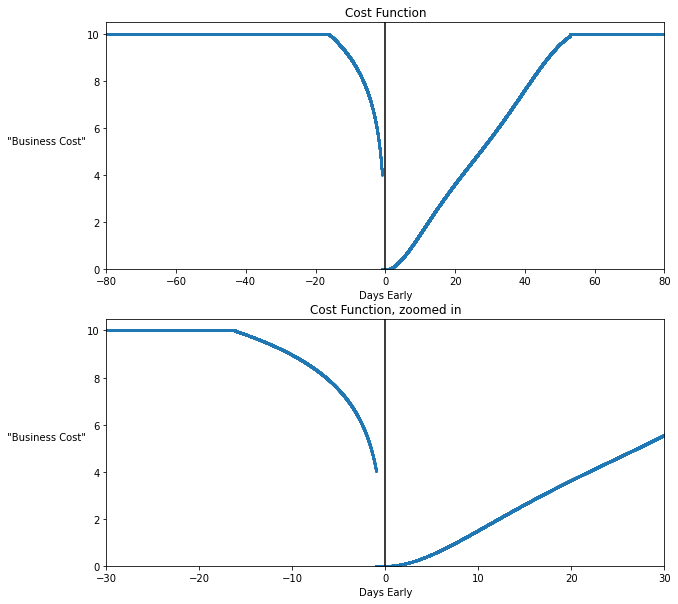

In [19]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(x_vals, y_vals, s=1)
ax1.axvline(x=0,c='black')
ax1.set_title('Cost Function')
ax1.set_xlabel('Days Early')
ax1.set_ylabel('"Business Cost"',rotation=0, labelpad=40)
ax1.set_xlim(-80,80)
ax1.set_ylim(0,10.5)
#ax1.text(-70, 2, 'Late Deliveries', size=10, color='black', weight='semibold')

ax2.scatter(x_vals, y_vals, s=1)
ax2.axvline(x=0,c='black')
ax2.set_title('Cost Function, zoomed in')
ax2.set_xlabel('Days Early')
ax2.set_ylabel('"Business Cost"',rotation=0, labelpad=40)
ax2.set_ylim(0,10.5)
ax2.set_xlim(-30,30)

plt.savefig('images/custom_cost_function.JPG',bbox_inches='tight', dpi=1200)
plt.show()

In [20]:
# Custom cost function for investigating results

# Defined cleaner cost function (that does the same thing) further down.
# This function is for better exploring the results (b/c it returns multiple different ways to look at the results)

def custom_evaluation_investigation(prediction_array, actual_array):
    
    days_early = prediction_array - actual_array
    
    late_count = 0
    ontime_count = 0
    early_count = 0

    business_cost_array = list()
    business_cost_sum = 0
    
    for i in days_early:

        if i > 53:
            business_cost = 10
            early_count+=1
        if (i > 0) & (i<=53):
            business_cost = 0.000000002618*(i**6)+-0.0000005570*(i**5)+0.00004377*(i**4)+-0.001607*(i**3)+0.02817*(i**2)+-0.007801*i+0.003387
            early_count+=1
        if (i <=0) & (i>=-1):
            business_cost = 0
            ontime_count+=1
        if (i < -1) & (i>=-16.2):
            #y = 0.000001845*(i**6)+0.0001167*(i**5)+0.00223*(i**4)+0.00258*(i**3)-0.3609*(i**2)-3.551*i-0.4503
            business_cost = 2.1451*np.log(abs(i))+4.0171
            late_count+=1
        if i<-16.2:
            business_cost = 10
            late_count+=1
                
                
        business_cost_sum += business_cost
        business_cost_array.append(business_cost)
 
        
        
    return ([late_count, ontime_count, early_count], business_cost_sum, business_cost_array)

In [21]:
# Custom cost function to use for training the model
# Just returns the overall business "cost"

def custom_cost_function(prediction_array, actual_array):
    
    days_early = prediction_array - actual_array

    business_cost_array = list()
    business_cost_sum = 0
    
    for i in days_early:

        if i > 53:
            business_cost = 10
 
        if (i > 0) & (i<=53):
            business_cost = 0.000000002618*(i**6)+-0.0000005570*(i**5)+0.00004377*(i**4)+-0.001607*(i**3)+0.02817*(i**2)+-0.007801*i+0.003387

        if (i <=0) & (i>=-1):
            business_cost = 0

        if (i < -1) & (i>=-16.2):
            business_cost = 2.1451*np.log(abs(i))+4.0171

        if i<-16.2:
            business_cost = 10
      
        business_cost_sum += business_cost   
    return business_cost_sum

#### Dummy Baseline Model(s)

In [22]:
# Dummy baseline model depends on the evaluation metric chosen...

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV

X = df[feature_list]
y = df['days_to_deliver']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=5)

# Median baseline
median_days_to_deliver_train = y_train.median()
dummy_prediction_array_median = np.full((len(y_test),), median_days_to_deliver_train)
#dummy_rmse = mean_squared_error(y_test, dummy_prediction_array_median)**0.5
#print('Dummy baseline RMSE:',dummy_rmse, '(using median as y_predicted).')
# Using custom scoring function (see above)
median_baseline_counts, median_baseline_cost, median_baseline_cost_array = custom_evaluation_investigation(dummy_prediction_array_median, y_test)


# Mean baseline
mean_days_to_deliver_train = y_train.mean()
dummy_prediction_array_mean = np.full((len(y_test),), mean_days_to_deliver_train)
#dummy_mae = mean_absolute_error(y_test, dummy_prediction_array_mean)**0.5
#print('Dummy baseline MAE:',dummy_mae, '(using mean as y_predicted).')
# Using custom scoring function (see above)
mean_baseline_counts, mean_baseline_cost, mean_baseline_cost_array = custom_evaluation_investigation(dummy_prediction_array_mean, y_test)



# Existing Olist prediction
Olist_prediction = df.loc[list(X_test.index),['Olist_estimated_days_to_deliver']]

# VERY IMPORTANT NOTE: Convert the Olist_prediction array from a dataframe to a numpy ndarray of (n,) shape
# Otherwise the program crashes b/c we are subtracting incompatible data types (y_test is an ndarray of (n,) shape)

# Originally: difference = dataframe - numpy array (n,) (computer crashes)
# Second revision: difference = numpy array (n,1) - numpy array (n,) (computer crashes)
# Final revision: difference = numpy array (n,) - numpy array (n,) (Executes very quickly)

Olist_prediction = np.array(Olist_prediction)
Olist_prediction = Olist_prediction.reshape(len(Olist_prediction),)

#olist_rmse = mean_squared_error(y_test, Olist_prediction)**0.5
#print('Olist RMSE:',olist_rmse, '.')
#olist_mae = mean_absolute_error(y_test, Olist_prediction)
#print('Olist MAE:',olist_mae, '.')

# Using custom scoring function
olist_prediction_counts, olist_prediction_cost, olist_prediction_cost_array = custom_evaluation_investigation(Olist_prediction, y_test)

view_df = pd.DataFrame({'Estimation':Olist_prediction, 'Actual':y_test, 'Cost':olist_prediction_cost_array})
view_df.head()

,Estimation,Actual,Cost
7741,34.125197,13.919549,3.687945
47695,24.337963,15.165625,1.336936
20165,18.405417,75.335313,10.000000
4139,25.187708,13.686470,1.854951
19152,37.382049,19.231019,3.279951


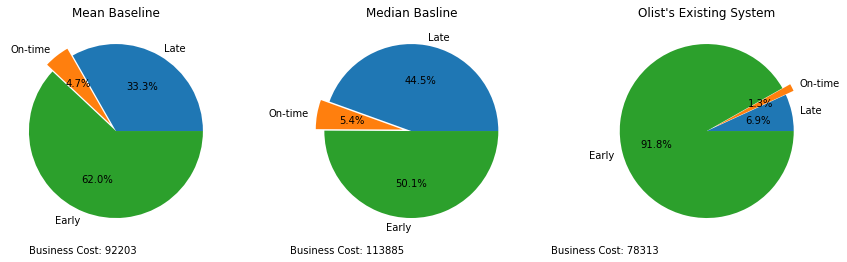

In [50]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
median_baseline_counts, median_baseline_cost, median_baseline_cost_array 

ax1.pie(x=mean_baseline_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax1.set_title("Mean Baseline")
ax1.text(-1,-1.4,'Business Cost: '+str(int(mean_baseline_cost)))

ax2.pie(x=median_baseline_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax2.set_title("Median Basline")
ax1.text(2,-1.4,'Business Cost: '+str(int(median_baseline_cost)))

ax3.pie(x=olist_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax3.set_title("Olist's Existing System")
ax1.text(5,-1.4,'Business Cost: '+str(int(olist_prediction_cost)))

plt.savefig('images/baseline_model_performance.JPG',bbox_inches='tight', dpi=1200)
plt.show()

<b>Observations</b>:

The delivery time prediction algorithm that Olist is currently using outperforms (when using the custom cost function to evaluate) both the dummy mean baseline model and the dummy median baseline model even though the Olist system resulted in less on-time deliveries (1.3% vs 4.7% and 5.4%, respectively).

The mean baseline model outperforms (when using the custom cost function to evaluate) the median baseline model because even though the mean baseline model resulted in less on-time deliveries, the median baseline model had more late deliveries. 

## Model Selection & Hyperparameter Tuning

I will be using the following algorithms:

<b>Generalized linear models</b>:<br>
1.) Simple linear regression <br>
2.) Linear regression w/ L1 Regularization<br>
3.) Linear regression w/ L2 Regularization <br>
4.) Linear regression w/ ElasticNet Regularization<br>

<b>Nearest-Neighbors model</b>:<br>
1.) KNeighborsRegressor<br>

<b>Tree-based models</b>: <br>
1.) Random Forest Regression (tree-based ensemble method)<br>
2.) AdaBoost Regression  (tree-based ensemble method)<br>
3.) Gradient Boosting Regression  (tree-based ensemble method)<br>

<b>Ensemble algorithms</b>:<br>
1.) Voting Regressor<br>

In [24]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import KFold

# Setting up my custom cost function
my_scorer = make_scorer(custom_cost_function, greater_is_better=False)

KF = KFold(n_splits=5, shuffle=True, random_state=5)

C:\Users\borch\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Generalized linear models

1.) Simple linear regression <br>
2.) Linear regression w/ L1 Regularization<br>
3.) Linear regression w/ L2 Regularization <br>
4.) Linear regression w/ ElasticNet Regularization<br>

### 1. General linear regression

In [25]:
# Feature Selection for general linear regression (don't need to do for lasso fyi)
feature_target_list = feature_list.copy()
feature_target_list.append('days_to_deliver')

# The features with the highest correlation are good indicators for how useful they will be for linear regression.
abs(df[feature_target_list].corr()['days_to_deliver']).sort_values(ascending=False)


# Need to check for collinearity. Will produce heatmap:

# Insert heatmap here...

days_to_deliver                1.000000
distance_est                   0.394640
freight_value_full_quantity    0.160248
shipping_limit_time            0.129361
same_metro                     0.092979
Customer_Urban                 0.083503
product_weight_g               0.080926
product_volume_cm3             0.072707
product_length_cm              0.065431
SUM(opm.payment_value)         0.032856
product_photos_qty             0.027731
product_description_height     0.002147
Seller_Urban                   0.001365
Name: days_to_deliver, dtype: float64

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

# X_train, X_test, y_train, y_test


slr = LinearRegression()

params_slr = {}

grid_slr = GridSearchCV(slr, param_grid=params_slr, scoring=my_scorer, cv=KF)

grid_slr.fit(X_train, y_train)

slr_best_estimator = grid_slr.best_estimator_
slr_best_params = grid_slr.best_params_
slr_best_score = grid_slr.best_score_

print(slr_best_estimator)
print(slr_best_params)
print(slr_best_score)


slr_test_predictions = slr_best_estimator.predict(X_test)
print(len(slr_test_predictions))
print(slr_test_predictions)

slr_prediction_counts, slr_prediction_cost, slr_prediction_cost_array = custom_evaluation_investigation(slr_test_predictions, y_test)

print(slr_prediction_cost)

LinearRegression()
{}
-54771.02533529418
30901
[10.64937023 10.94785717 11.08406508 ... 19.17037108 13.96186486
 11.95644763]
82266.12376034385


### 2. Lasso regression (L1 penalty)

In [27]:
from sklearn.linear_model import Lasso

lasso_params ={
        "alpha": [0.001, 0.002, 0.004, 0.009, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3,],
}

lasso_model = Lasso(random_state=6)


grid_lasso = GridSearchCV(lasso_model, param_grid=lasso_params, scoring=my_scorer, cv=KF)

grid_lasso.fit(X_train, y_train)

lasso_best_estimator = grid_lasso.best_estimator_
lasso_best_params = grid_lasso.best_params_
lasso_best_score = grid_lasso.best_score_

print(lasso_best_estimator)
print(lasso_best_params)
print(lasso_best_score)


lasso_test_predictions = lasso_best_estimator.predict(X_test)
print(len(lasso_test_predictions))
print(lasso_test_predictions)

lasso_prediction_counts, lasso_prediction_cost, lasso_prediction_cost_array = custom_evaluation_investigation(lasso_test_predictions, y_test)

print(lasso_prediction_cost)

Lasso(alpha=0.001, random_state=6)
{'alpha': 0.001}
-54780.63130506013
30901
[10.6463117  10.9453989  11.08255216 ... 19.17166876 13.9617426
 11.95654532]
82260.19804910972


In [28]:
print(lasso_best_estimator.coef_)
print(lasso_best_estimator.sparse_coef_)

[ 9.96022347e-03  1.12143890e-04  1.46562110e-04  2.05550450e-02
 -7.30110427e-01  8.28777245e-02 -6.09507195e-03  1.77850460e-01
  1.07267400e-06 -3.07814177e+00 -1.97766488e-04 -1.74209652e-01]
  (0, 0)	0.009960223467711677
  (0, 1)	0.00011214388998001338
  (0, 2)	0.00014656210968882897
  (0, 3)	0.02055504501001079
  (0, 4)	-0.7301104269664924
  (0, 5)	0.08287772450406708
  (0, 6)	-0.006095071953633037
  (0, 7)	0.17785046040440677
  (0, 8)	1.0726739982565077e-06
  (0, 9)	-3.078141766812143
  (0, 10)	-0.0001977664877788804
  (0, 11)	-0.17420965180249387


### 3. Ridge regression (L2 penalty)

In [29]:
from sklearn.linear_model import Ridge

params_ridge ={
        "alpha": [0, 0.000001, 0.001, 0.01, 0.1, 1,5, 10, 12, 15, 17, 17.5, 18],
}

ridge_model = Ridge(random_state=10)


grid_ridge = GridSearchCV(ridge_model, param_grid=params_ridge, scoring=my_scorer, cv=KF)

grid_ridge.fit(X_train, y_train)

ridge_best_estimator = grid_ridge.best_estimator_
ridge_best_params = grid_ridge.best_params_
ridge_best_score = grid_ridge.best_score_

print(ridge_best_estimator)
print(ridge_best_params)
print(ridge_best_score)


ridge_test_predictions = ridge_best_estimator.predict(X_test)
print(len(ridge_test_predictions))
print(ridge_test_predictions)

ridge_prediction_counts, ridge_prediction_cost, ridge_prediction_cost_array = custom_evaluation_investigation(ridge_test_predictions, y_test)

print(ridge_prediction_cost)

Ridge(alpha=0, random_state=10)
{'alpha': 0}
-54771.025335294195
30901
[10.64937023 10.94785717 11.08406508 ... 19.17037108 13.96186486
 11.95644763]
82266.12376034386


### 4. ElasticNet regression

In [30]:
from sklearn.linear_model import ElasticNet

params_elasticnet ={
        "alpha": [0.0005, 0.00055, 0.0006, 0.0007, 0.0008, 0.0009, 0.001],
        "l1_ratio": [0.5, 0.75, 0.85, 0.90, 0.95, 0.975, 0.99, 1]
}

elasticnet_model = ElasticNet(random_state=7)

grid_elasticnet = GridSearchCV(elasticnet_model, param_grid=params_elasticnet, scoring=my_scorer, cv=KF)

grid_elasticnet.fit(X_train, y_train)

elasticnet_best_estimator = grid_elasticnet.best_estimator_
elasticnet_best_params = grid_elasticnet.best_params_
elasticnet_best_score = grid_elasticnet.best_score_

print(elasticnet_best_estimator)
print(elasticnet_best_params)
print(elasticnet_best_score)


elasticnet_test_predictions = elasticnet_best_estimator.predict(X_test)
print(len(elasticnet_test_predictions))
print(elasticnet_test_predictions)

elasticnet_prediction_counts, elasticnet_prediction_cost, elasticnet_prediction_cost_array = custom_evaluation_investigation(elasticnet_test_predictions, y_test)

print(elasticnet_prediction_cost)

ElasticNet(alpha=0.0007, l1_ratio=1, random_state=7)
{'alpha': 0.0007, 'l1_ratio': 1}
-54774.748733164124
30901
[10.64722926 10.94613638 11.08300603 ... 19.17127946 13.96177928
 11.95651601]
82263.43976616603


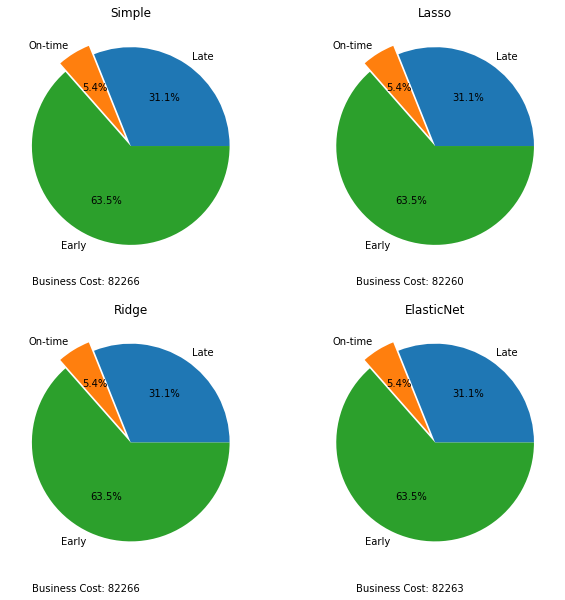

In [31]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.pie(x=slr_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax1.set_title("Simple")
ax1.text(-1,-1.4,'Business Cost: '+str(int(slr_prediction_cost)))

ax2.pie(x=lasso_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax2.set_title("Lasso")
ax2.text(-0.8,-1.4,'Business Cost: '+str(int(lasso_prediction_cost)))

ax3.pie(x=ridge_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax3.set_title("Ridge")
ax3.text(-1,-1.5,'Business Cost: '+str(int(ridge_prediction_cost)))

ax4.pie(x=elasticnet_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax4.set_title("ElasticNet")
ax4.text(-0.8,-1.5,'Business Cost: '+str(int(elasticnet_prediction_cost)))

plt.savefig('images/linear_regression_performance.JPG',bbox_inches='tight', dpi=1200)
plt.show()

<b>Observations</b>:

Why am I getting the exact same results for all 4 cases (note that the results are SLIGTLY different if you look at the business cost down to the decimals).

## Nearest Neighbors Regression

In [32]:
# Need to normalize the features for this algorithm

from sklearn.preprocessing import MinMaxScaler

#Some of the numerical features still need to be normalized
normalize_feature_list = ['distance_est', 'SUM(opm.payment_value)', 'product_weight_g', 'product_length_cm']

df_new = df.copy()

#StandardScaler's fit and transform methods require an input of an ndarray
normalize_ndarray = df_new[normalize_feature_list].values

# Default range is (0,1)
scaler = MinMaxScaler()
scaler.fit(normalize_ndarray)
scaled_values_ndarray = scaler.transform(normalize_ndarray)


#Need to combine this ndarray back into a DataFrame:
df_new.loc[:,normalize_feature_list] = scaled_values_ndarray

df_new['product_weight_g'].describe()

X_norm = df_new[normalize_feature_list]
y_1 = df_new['days_to_deliver']

X_train_norm, X_test_norm, y_1_train, y_1_test = train_test_split(X_norm, y_1, test_size=0.333, random_state=5)

In [33]:
from sklearn.neighbors import KNeighborsRegressor

knr_model = KNeighborsRegressor()

params_knr ={
                    "n_neighbors": [10,20],
                    "weights": ["distance", "uniform"],
                    #"algorithm": ["ball_tree", "kd_tree", "brute"],
                    #"p": [1,2]

}


grid_knr = GridSearchCV(knr_model, param_grid=params_knr, scoring=my_scorer, cv=KF)

grid_knr.fit(X_train_norm, y_1_train)

knr_best_estimator = grid_knr.best_estimator_
knr_best_params = grid_knr.best_params_
knr_best_score = grid_knr.best_score_

print(knr_best_estimator)
print(knr_best_params)
print(knr_best_score)


knr_test_predictions = knr_best_estimator.predict(X_test_norm)
print(len(knr_test_predictions))
print(knr_test_predictions)

knr_prediction_counts, knr_prediction_cost, knr_prediction_cost_array = custom_evaluation_investigation(knr_test_predictions, y_1_test)

print(knr_prediction_cost)

KNeighborsRegressor(n_neighbors=10, weights='distance')
{'n_neighbors': 10, 'weights': 'distance'}
-51531.01724520918
30901
[11.23991899  8.60730285 12.34146237 ... 20.14794536 13.7498407
 14.79169688]
90247.32094381105


## Tree-based models:
1. Decision tree 
2. Random Forest regression (tree-based ensemble method)
3. Gradient Boosting regression (tree-based ensemble method)
4. Adaboost regression (tree-based ensemble method)


### 1. Decision tree

In [34]:
from sklearn.tree import DecisionTreeRegressor

dtree_model = DecisionTreeRegressor(random_state=3)

#We are preventing overfitting in this decision tree regression by: 
#1. Pruning the decision tree (after it has been built), removing unneccessary leaves 
#2. Restricting the depth of the decision tree (while we are building the tree)

# Need to tune the hyperparameters. Currently don't have many b/c want to reduce the runtime.
params_dtree ={
        "criterion": ["mse"],
        "max_depth": [20],
        "max_features": ["log2", "sqrt"],
        "min_samples_leaf": [16],
        "min_samples_split": [10]
}

grid_dtree = GridSearchCV(dtree_model, param_grid=params_dtree, scoring=my_scorer, cv=KF)

grid_dtree.fit(X_train, y_train)

dtree_best_estimator = grid_dtree.best_estimator_
dtree_best_params = grid_dtree.best_params_
dtree_best_score = grid_dtree.best_score_

print(dtree_best_estimator)
print(dtree_best_params)
print(dtree_best_score)


dtree_test_predictions = dtree_best_estimator.predict(X_test)
print(len(dtree_test_predictions))
print(dtree_test_predictions)

dtree_prediction_counts, dtree_prediction_cost, dtree_prediction_cost_array = custom_evaluation_investigation(dtree_test_predictions, y_test)

print(dtree_prediction_cost)

DecisionTreeRegressor(max_depth=20, max_features='log2', min_samples_leaf=16,
                      min_samples_split=10, random_state=3)
{'criterion': 'mse', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 10}
-50901.572645017404
30901
[ 8.15815438 12.93535836  7.31341628 ... 18.09178737 11.72653241
 14.79417329]
86299.6667061258


### 2. Random Forest Regression

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=55)

# Need to tune the hyperparameters. Currently don't have many b/c want to reduce the runtime.

params_rf = {
        "n_estimators": [25],
        "criterion": ["mse"],
        "max_depth": [10],
        "max_features": ["sqrt"],
        "min_samples_leaf": [1],
        "min_samples_split": [3]
}


grid_rf = GridSearchCV(rf_model, param_grid=params_rf, scoring=my_scorer, cv=KF)

grid_rf.fit(X_train, y_train)

rf_best_estimator = grid_rf.best_estimator_
rf_best_params = grid_rf.best_params_
rf_best_score = grid_rf.best_score_

print(rf_best_estimator)
print(rf_best_params)
print(rf_best_score)


rf_test_predictions = rf_best_estimator.predict(X_test)
print(len(rf_test_predictions))
print(rf_test_predictions)

rf_prediction_counts, rf_prediction_cost, rf_prediction_cost_array = custom_evaluation_investigation(rf_test_predictions, y_test)

print(rf_prediction_cost)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=3,
                      n_estimators=25, random_state=55)
{'criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 25}
-53071.80158830199
30901
[ 9.08411053 12.97779055 11.44077169 ... 19.30559403 14.61793347
 13.53363675]
78567.22082586076


In [36]:
feature_importances_df = pd.DataFrame({'Feature': list(X_train.columns), 'Importance':rf_best_estimator.feature_importances_})

feature_importances_df.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
0,distance_est,0.443591
6,freight_value_full_quantity,0.212337
7,shipping_limit_time,0.137661
1,SUM(opm.payment_value),0.045324
8,product_volume_cm3,0.036794
10,product_description_height,0.036010
2,product_weight_g,0.035810
3,product_length_cm,0.026354
11,product_photos_qty,0.013571
9,same_metro,0.006973


### 3. Gradient Boosting regression

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=22)

params_gbm ={
        #"loss": ['ls', 'lad', 'huber'],
        "loss": ['ls'],
        "n_estimators": [100],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8],
        "max_depth": [5, 10],
        "max_features": ["sqrt"],
        "min_samples_leaf": [5, 8],
        "min_samples_split": [10]
}


grid_gbm = GridSearchCV(gbm, param_grid=params_gbm, scoring=my_scorer, cv=KF)

grid_gbm.fit(X_train, y_train)

gbm_best_estimator = grid_gbm.best_estimator_
gbm_best_params = grid_gbm.best_params_
gbm_best_score = grid_gbm.best_score_

print(gbm_best_estimator)
print(gbm_best_params)
print(gbm_best_score)


gbm_test_predictions = gbm_best_estimator.predict(X_test)
print(len(gbm_test_predictions))
print(gbm_test_predictions)

gbm_prediction_counts, gbm_prediction_cost, gbm_prediction_cost_array = custom_evaluation_investigation(gbm_test_predictions, y_test)

print(gbm_prediction_cost)

GradientBoostingRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=10, random_state=22, subsample=0.8)
{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
-51092.56167109605
30901
[10.37613513 12.37983174 11.11193099 ... 19.93937485 14.09842728
 13.38108643]
78425.55732857209


### 4. Adaboost

In [52]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=3)

params_ada ={
        "n_estimators": [10],
        "learning_rate": [0.05, 0.5],
        "loss": ['linear']
}

grid_ada = GridSearchCV(ada, param_grid=params_ada, scoring=my_scorer, cv=KF)

grid_ada.fit(X_train, y_train)

ada_best_estimator = grid_ada.best_estimator_
ada_best_params = grid_ada.best_params_
ada_best_score = grid_ada.best_score_

print(ada_best_estimator)
print(ada_best_params)
print(ada_best_score)


ada_test_predictions = ada_best_estimator.predict(X_test)
print(len(ada_test_predictions))
print(ada_test_predictions)

ada_prediction_counts, ada_prediction_cost, ada_prediction_cost_array = custom_evaluation_investigation(ada_test_predictions, y_test)

print(ada_prediction_cost)

AdaBoostRegressor(learning_rate=0.05, n_estimators=10, random_state=3)
{'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 10}
-54910.06683219121
30901
[ 8.79677577 13.69611987 12.97799279 ... 20.70470594 14.14222132
 14.14222132]
79760.63432506751


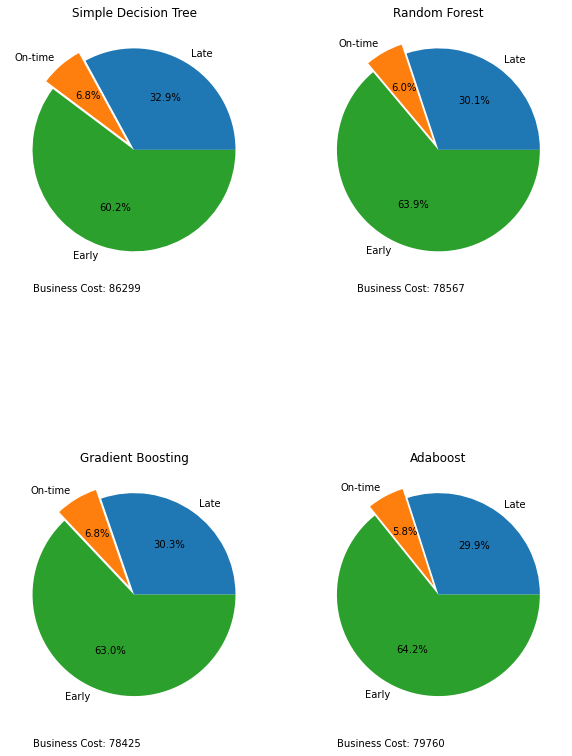

In [53]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)



ax1.pie(x=dtree_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax1.set_title("Simple Decision Tree")
ax1.text(-1,-1.4,'Business Cost: '+str(int(dtree_prediction_cost)))

ax2.pie(x=rf_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax2.set_title("Random Forest")
ax2.text(-0.8,-1.4,'Business Cost: '+str(int(rf_prediction_cost)))

ax3.pie(x=gbm_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax3.set_title("Gradient Boosting")
ax3.text(-1,-1.5,'Business Cost: '+str(int(gbm_prediction_cost)))

ax4.pie(x=ada_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax4.set_title("Adaboost")
ax4.text(-1,-1.5,'Business Cost: '+str(int(ada_prediction_cost)))

plt.savefig('images/tree_performance.JPG',bbox_inches='tight', dpi=1200)
plt.show()

### Stacking w/ Voting Regression
Implemented an ensemble algorithm that combined the best two performing models: random forest and gradient-boosting.

In [44]:
from sklearn.ensemble import VotingRegressor

params_ensemble = {
                'weights': [[0.5,0.5], [0.25, 0.75], [0.75,0.25]]}
#the estimator parameter needs to be a list of (string, estimator) tuples:
estimators=[('gbm', gbm_best_estimator), ('rf', rf_best_estimator)]

ensemble_model = VotingRegressor(estimators)

grid_ensemble = GridSearchCV(ensemble_model, param_grid=params_ensemble, scoring=my_scorer, cv=KF)

grid_ensemble.fit(X_train, y_train)

ensemble_best_estimator = grid_ensemble.best_estimator_
ensemble_best_params = grid_ensemble.best_params_
ensemble_best_score = grid_ensemble.best_score_

print(ensemble_best_estimator)
print(ensemble_best_params)
print(ensemble_best_score)


ensemble_test_predictions = ensemble_best_estimator.predict(X_test)
print(len(ensemble_test_predictions))
print(ensemble_test_predictions)

ensemble_prediction_counts, ensemble_prediction_cost, ensemble_prediction_cost_array = custom_evaluation_investigation(ensemble_test_predictions, y_test)

print(ensemble_prediction_cost)                            

VotingRegressor(estimators=[('gbm',
                             GradientBoostingRegressor(max_depth=10,
                                                       max_features='sqrt',
                                                       min_samples_leaf=5,
                                                       min_samples_split=10,
                                                       random_state=22,
                                                       subsample=0.8)),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   max_features='sqrt',
                                                   min_samples_split=3,
                                                   n_estimators=25,
                                                   random_state=55))],
                weights=[0.75, 0.25])
{'weights': [0.75, 0.25]}
-51632.486229231894
30901
[10.05312898 12.52932145 11.19414117 ... 19.780929

### Results Comparison

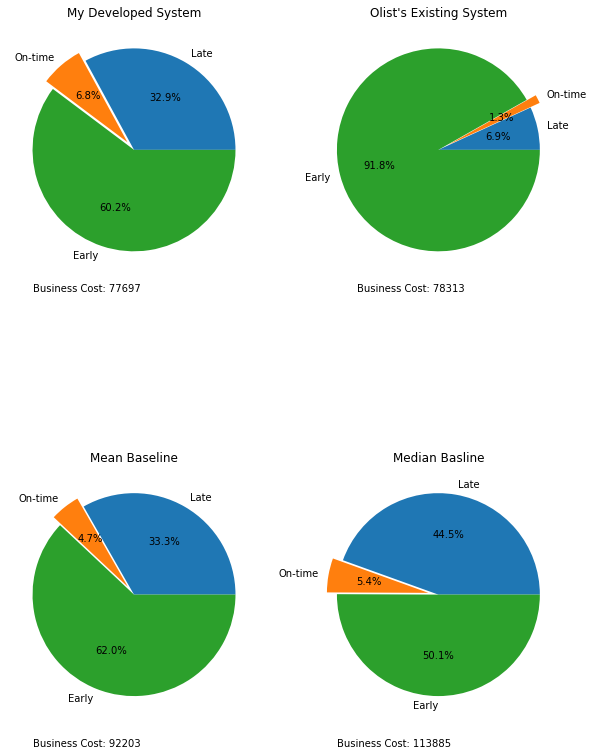

In [51]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)



ax1.pie(x=dtree_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax1.set_title("My Developed System")
ax1.text(-1,-1.4,'Business Cost: '+str(int(ensemble_prediction_cost)))

ax2.pie(x=olist_prediction_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax2.set_title("Olist's Existing System")
ax2.text(-0.8,-1.4,'Business Cost: '+str(int(olist_prediction_cost)))

ax3.pie(x=mean_baseline_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax3.set_title("Mean Baseline")
ax3.text(-1,-1.5,'Business Cost: '+str(int(mean_baseline_cost)))

ax4.pie(x=median_baseline_counts, labels=['Late', 'On-time', 'Early'], autopct='%1.1f%%', explode=(0,0.1,0))
ax4.set_title("Median Basline")
ax4.text(-1,-1.5,'Business Cost: '+str(int(median_baseline_cost)))

plt.savefig('images/results_comparison.JPG',bbox_inches='tight', dpi=1200)
plt.show()

The system I developed has a similar "business cost" score to the existing system employed by Olist. 
- My system has significantly more on-time orders (6.8% vs 1.3%)
- My system has less early orders (60.2% vs 91.8%) but subtantially more late orders (32.9% vs 6.9%).
- Depending on what the true business cost model is, one model may perform much better than the other. At this point it is completely unknown.

Next steps:
-  Could spend way more time tuning my various models as well as determining optimal feature selection. 
- Collect and analyze Olist financial data to better quantify the "business cost" of late orders vs early orders (I don't have access to this data).
